# Making custom colour maps
---
This notebook is part 5/5 of a tutorial based on the [```colourspace```](https://github.com/gillesferrand/colourspace) package.

In [1]:
from colourspace import maps

convertor = ' custom '


The ```maps``` module deals with the custom generation of perceptually-correct colour maps. Working in LCH allows us to manipulate independently the three dimensions of colours: lightness, chroma, hue. We will demonstrate this with three kinds of cmaps, that cannot be easily produced when working in RGB or its derivatives:
- equi-luminant, stepping in H at Cmax
- diverging, stepping in C at a given L from one H to another
- mono-hue, stepping in L at Cmax

For each map, we draw a simple path in LCH space for each coordinate, then convert the list of colours to RGB using ```convert```. For all three cmap making functions, ```res``` is the number of steps per unit of the quantity L,C,H that is being stepped through. As before, colours out of the sRGB gamut are discarded if ```mode='crop'```, or just have their values clipped if ```mode='clip'``` (```'clip'``` cmaps are more vivid, but less uniform, than ```'crop'``` cmaps). Finally ```generate_cmaps()``` is called, that will <br>
\- write the cmap as a PNG image file if ```'png'``` is in ```targets``` (with a width equal to the number of steps, and an arbitrary height); <br>
\- turn it into a Matplotlib cmap object if ```'mpl'``` is in ```targets``` (it can then be applied on an image of any width and height), this is stored in the ```CMAP``` dictionnary (it can also be added to Matplotlib's internal list of cmaps using ```register_to_mpl()```).<br>
The function ```test_cmaps()``` can be used to test the Matplotlib cmaps, listed by name, on dummy data.

In [2]:
%matplotlib inline

In [3]:
figsize_x = 6
figsize_y = 6

png_dir = "./maps"

## Equi-luminant cmaps

Function ```make_cmap_equilum()``` draws a curve at constant L in the LH plane, in the chosen H range, at the Cmax for this L.

In [4]:
maps.make_cmap_equilum(L=70, H=[0,360], Hres=1, png_dir=png_dir)

loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res10_full.npy
creating cmap 'equilum_L070_H000-360_clip' for Matplotlib ( 361 steps)
writing ./maps/cmap_equilum_L070_H000-360_clip.png (32x361)
loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res10_sRGB.npy
creating cmap 'equilum_L070_H000-360_crop' for Matplotlib ( 361 steps)
writing ./maps/cmap_equilum_L070_H000-360_crop.png (32x361)


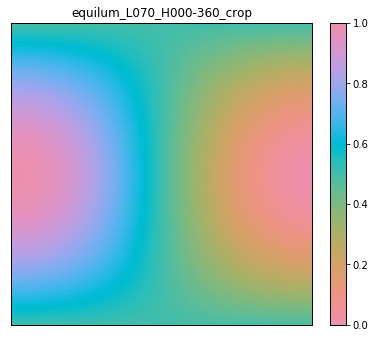

In [5]:
maps.test_cmaps(names=["equilum_L070_H000-360_crop"],figsize=(figsize_x,figsize_y),fname="")

Because the eye cannot see clear edges, the colours may seem to be vibrating. Such a colour map is maybe more useful for discrete sampling, e.g. applied to a set of curves. Its interest is to produce a rainbow palette that is far more uniform than the one made in RGB.

In [6]:
maps.make_cmap_equilum(L=70, H=[0,290], Hres=1, png_dir=png_dir)

creating cmap 'equilum_L070_H000-290_clip' for Matplotlib ( 291 steps)
writing ./maps/cmap_equilum_L070_H000-290_clip.png (32x291)
creating cmap 'equilum_L070_H000-290_crop' for Matplotlib ( 291 steps)
writing ./maps/cmap_equilum_L070_H000-290_crop.png (32x291)


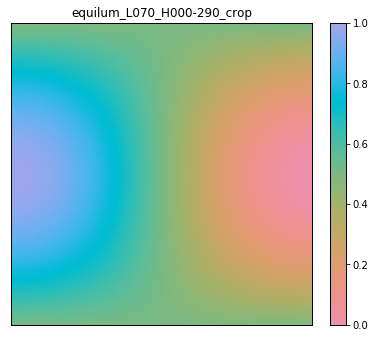

In [7]:
maps.test_cmaps(names=["equilum_L070_H000-290_crop"],figsize=(figsize_x,figsize_y),fname="")

Note: any continuous cmap can be made discrete (binned) by resampling its colours, this is offered with the optional parameter ```nstep```.

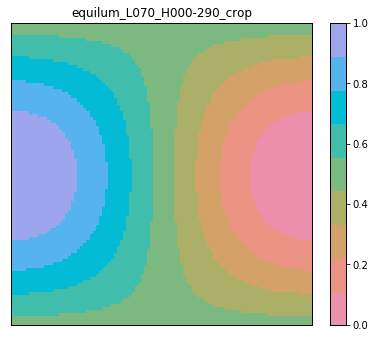

In [8]:
maps.test_cmaps(names=["equilum_L070_H000-290_crop"],figsize=(figsize_x,figsize_y),fname="",nsteps=9)

A more limited range:

In [9]:
maps.make_cmap_equilum(L=70, H=[240,0], Hres=1, png_dir=png_dir)

creating cmap 'equilum_L070_H240-000_clip' for Matplotlib ( 122 steps)
writing ./maps/cmap_equilum_L070_H240-000_clip.png (32x122)
creating cmap 'equilum_L070_H240-000_crop' for Matplotlib ( 122 steps)
writing ./maps/cmap_equilum_L070_H240-000_crop.png (32x122)


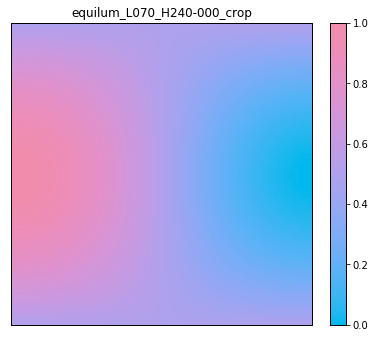

In [10]:
maps.test_cmaps(names=["equilum_L070_H240-000_crop"],figsize=(figsize_x,figsize_y),fname="")

## Diverging cmaps

Function ```make_cmap_diverging()``` draws a path from H1 at max chroma to H2 at max chroma, at a given L
(if ```sym==True``` then Cmax is set for both hues, otherwise for each hue independently).

In [11]:
maps.make_cmap_diverging(H1=30+180, H2=30, L=60, Cres=1, sym=True, png_dir=png_dir)

creating cmap 'diverging_L060_H210-030_clip' for Matplotlib ( 171 steps)
writing ./maps/cmap_diverging_L060_H210-030_clip.png (32x171)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib (  69 steps)
writing ./maps/cmap_diverging_L060_H210-030_crop.png (32x69)


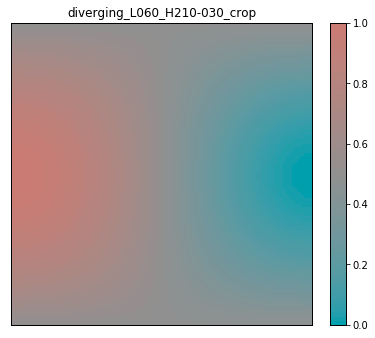

In [12]:
maps.test_cmaps(names=["diverging_L060_H210-030_crop"],figsize=(figsize_x,figsize_y),fname="")

Such a colour map is useful for data that have a natural threshold value, e.g. negative and positive values. (The neutral point has to stay anchored at the chosen threshold value, even when the overal range varies.)

This colour map above made with symmetric chroma on both hue sides. The version below shows that, at this L, the red at H=30 can reach a higher C than the cyan at H=210. 

In [13]:
maps.make_cmap_diverging(H1=30+180, H2=30, L=60, Cres=1, sym=False, png_dir=png_dir)

creating cmap 'diverging_L060_H210-030_clip' for Matplotlib ( 180 steps)
writing ./maps/cmap_diverging_L060_H210-030_clip.png (32x180)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib ( 109 steps)
writing ./maps/cmap_diverging_L060_H210-030_crop.png (32x109)


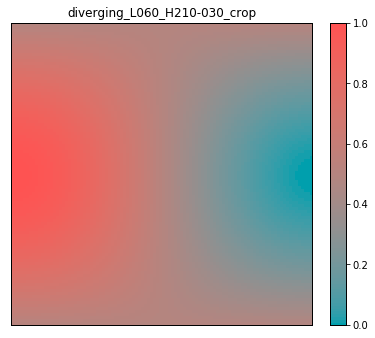

In [14]:
maps.test_cmaps(names=["diverging_L060_H210-030_crop"],figsize=(figsize_x,figsize_y),fname="")

Diverging cmaps can also be made 2D, with the other axis being the lightness: each row is a 1D cmap like the one plotted above. <br>
Function ```make_cmap_diverging2D()```, for a given range of L, stitches the half planes H=H1 and H=H2 along the gray axis, each extended to Cmax.<br>
(if ```sym==True``` then Cmax is set for both hues, otherwise for each hue independently)

In [15]:
maps.make_cmap_diverging2D(H1=30+180, H2=30, L=[0,100], Lres=1, Csteps=128, png_dir=png_dir)

writing ./maps/cmap_diverging2D_L000-100_H210-030_clip.png (101x257)
writing ./maps/cmap_diverging2D_L000-100_H210-030_crop.png (101x257)


Such bi-variate cmaps may be used manually, but cannot be readily used with Matplotlib (see [issue 4369](https://github.com/matplotlib/matplotlib/issues/4369)).

## Mono-hue cmaps

Function ```make_cmap_monohue()```, for a given H, draws a path from L[0] to L[1] at the maximal C. 
(if ```sym==True``` then Cmax is set for both L and 100-L, otherwise for each L independently).

In [16]:
maps.make_cmap_monohue(H=30, L=[  0, 50], Lres=1, sym=True, png_dir=png_dir)
maps.make_cmap_monohue(H=30, L=[100, 50], Lres=1, sym=True, png_dir=png_dir)
maps.make_cmap_monohue(H=30, L=[  0,100], Lres=1, sym=True, png_dir=png_dir)

creating cmap 'monohue_L000-050_H030_clip' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L000-050_H030_clip.png (32x51)
creating cmap 'monohue_L000-050_H030_crop' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L000-050_H030_crop.png (32x51)
creating cmap 'monohue_L100-050_H030_clip' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L100-050_H030_clip.png (32x51)
creating cmap 'monohue_L100-050_H030_crop' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L100-050_H030_crop.png (32x51)
creating cmap 'monohue_L000-100_H030_clip' for Matplotlib ( 101 steps)
writing ./maps/cmap_monohue_L000-100_H030_clip.png (32x101)
creating cmap 'monohue_L000-100_H030_crop' for Matplotlib ( 101 steps)
writing ./maps/cmap_monohue_L000-100_H030_crop.png (32x101)


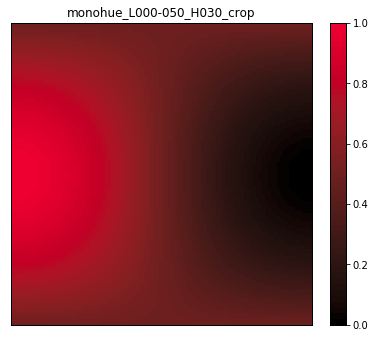

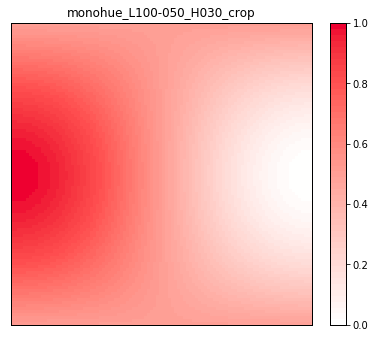

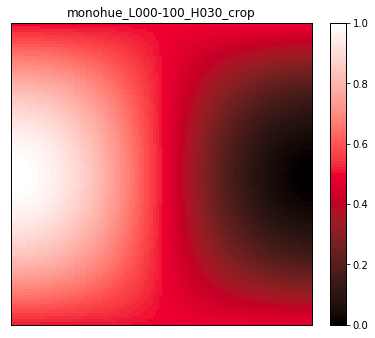

In [17]:
maps.test_cmaps(names=["monohue_L000-050_H030_crop","monohue_L100-050_H030_crop","monohue_L000-100_H030_crop"],figsize=(figsize_x,figsize_y),fname="")

When using such cmaps hue can be used to code something other than the data value, e.g. a data category.

## A selection of cmaps

Function ```make_cmap_favs(types,modes,targets)``` generates and writes a set of predefined cmaps of the above types. (Note that, for each case in ```types``` and ```modes```, the ```CMAP``` dictionnary will be reset.)

Function ```plot_cmaps()``` plots all the cmaps present in ```CMAP```, and writes them as PNG images of normalized width and height.

In [18]:
figsize_x = 10
figsize_y = 0.8

### Equi-luminant

In [19]:
maps.make_cmap_favs(types=['equilum'], modes=['crop'], targets=['mpl'], plot=False)

-------
equilum
-------
creating cmap 'equilum_L020_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L030_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L040_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L050_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L060_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L070_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L080_H000-250_crop' for Matplotlib ( 501 steps)


found cmaps:  ['equilum_L080_H000-250_crop', 'equilum_L070_H000-250_crop', 'equilum_L060_H000-250_crop', 'equilum_L050_H000-250_crop', 'equilum_L040_H000-250_crop', 'equilum_L030_H000-250_crop', 'equilum_L020_H000-250_crop']
writing  ./maps/cmap256_equilum_L080_H000-250_crop.png
writing  ./maps/cmap256_equilum_L070_H000-250_crop.png
writing  ./maps/cmap256_equilum_L060_H000-250_crop.png
writing  ./maps/cmap256_equilum_L050_H000-250_crop.png
writing  ./maps/cmap256_equilum_L040_H000-250_crop.png
writing  ./maps/cmap256_equilum_L030_H000-250_crop.png
writing  ./maps/cmap256_equilum_L020_H000-250_crop.png
writing  ./maps/cmaps_equi-luminant colour maps (crop mode).png


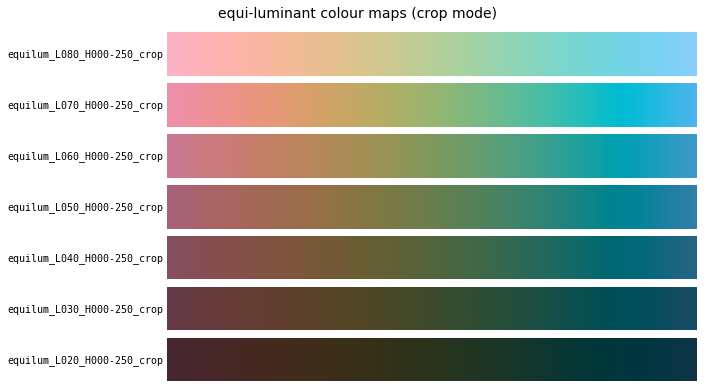

In [20]:
maps.plot_cmaps(figsize=(figsize_x,figsize_y*7), dir=png_dir, title="equi-luminant colour maps (crop mode)")

In [21]:
maps.make_cmap_favs(types=['equilum'], modes=['clip'], targets=['mpl'], plot=False)

-------
equilum
-------
creating cmap 'equilum_L020_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L030_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L040_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L050_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L060_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L070_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L080_H000-250_clip' for Matplotlib ( 501 steps)


found cmaps:  ['equilum_L080_H000-250_clip', 'equilum_L070_H000-250_clip', 'equilum_L060_H000-250_clip', 'equilum_L050_H000-250_clip', 'equilum_L040_H000-250_clip', 'equilum_L030_H000-250_clip', 'equilum_L020_H000-250_clip']
writing  ./maps/cmap256_equilum_L080_H000-250_clip.png
writing  ./maps/cmap256_equilum_L070_H000-250_clip.png
writing  ./maps/cmap256_equilum_L060_H000-250_clip.png
writing  ./maps/cmap256_equilum_L050_H000-250_clip.png
writing  ./maps/cmap256_equilum_L040_H000-250_clip.png
writing  ./maps/cmap256_equilum_L030_H000-250_clip.png
writing  ./maps/cmap256_equilum_L020_H000-250_clip.png
writing  ./maps/cmaps_equi-luminant colour maps (clip mode).png


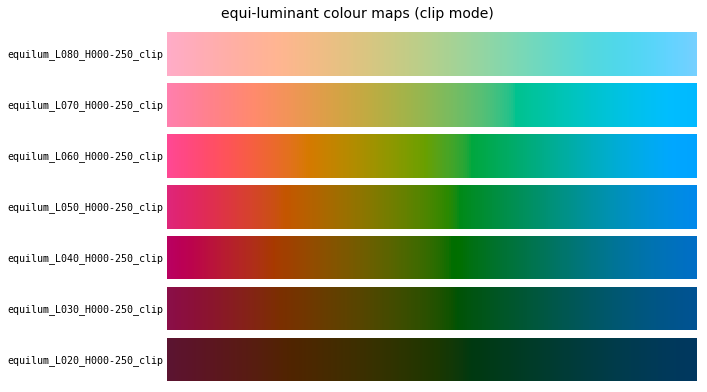

In [22]:
maps.plot_cmaps(figsize=(figsize_x,figsize_y*7), dir=png_dir, title="equi-luminant colour maps (clip mode)")

### Diverging

In [23]:
maps.make_cmap_favs(types=['diverging'], modes=['crop'], targets=['mpl'], plot=False)

---------
diverging
---------
creating cmap 'diverging_L020_H210-030_crop' for Matplotlib ( 129 steps)
creating cmap 'diverging_L030_H210-030_crop' for Matplotlib ( 165 steps)
creating cmap 'diverging_L040_H210-030_crop' for Matplotlib ( 201 steps)
creating cmap 'diverging_L050_H210-030_crop' for Matplotlib ( 237 steps)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib ( 273 steps)
creating cmap 'diverging_L070_H210-030_crop' for Matplotlib ( 309 steps)
creating cmap 'diverging_L080_H210-030_crop' for Matplotlib ( 245 steps)


found cmaps:  ['diverging_L080_H210-030_crop', 'diverging_L070_H210-030_crop', 'diverging_L060_H210-030_crop', 'diverging_L050_H210-030_crop', 'diverging_L040_H210-030_crop', 'diverging_L030_H210-030_crop', 'diverging_L020_H210-030_crop']
writing  ./maps/cmap256_diverging_L080_H210-030_crop.png
writing  ./maps/cmap256_diverging_L070_H210-030_crop.png
writing  ./maps/cmap256_diverging_L060_H210-030_crop.png
writing  ./maps/cmap256_diverging_L050_H210-030_crop.png
writing  ./maps/cmap256_diverging_L040_H210-030_crop.png
writing  ./maps/cmap256_diverging_L030_H210-030_crop.png
writing  ./maps/cmap256_diverging_L020_H210-030_crop.png
writing  ./maps/cmaps_diverging colour maps (crop mode).png


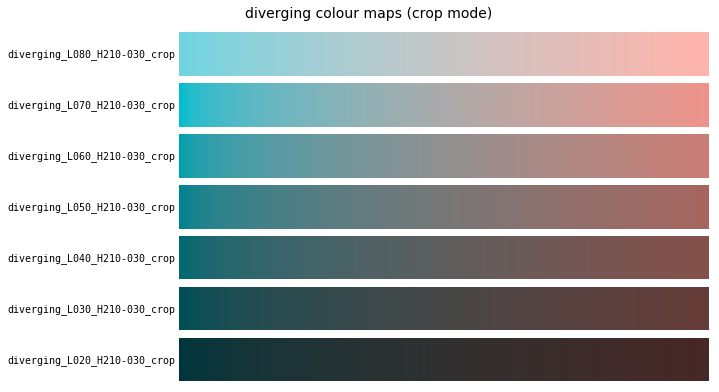

In [24]:
maps.plot_cmaps(figsize=(figsize_x,figsize_y*7), dir=png_dir, title="diverging colour maps (crop mode)")

In [25]:
maps.make_cmap_favs(types=['diverging'], modes=['clip'], targets=['mpl'], plot=False)

---------
diverging
---------
creating cmap 'diverging_L020_H210-030_clip' for Matplotlib ( 447 steps)
creating cmap 'diverging_L030_H210-030_clip' for Matplotlib ( 549 steps)
creating cmap 'diverging_L040_H210-030_clip' for Matplotlib ( 625 steps)
creating cmap 'diverging_L050_H210-030_clip' for Matplotlib ( 669 steps)
creating cmap 'diverging_L060_H210-030_clip' for Matplotlib ( 681 steps)
creating cmap 'diverging_L070_H210-030_clip' for Matplotlib ( 647 steps)
creating cmap 'diverging_L080_H210-030_clip' for Matplotlib ( 485 steps)


found cmaps:  ['diverging_L080_H210-030_clip', 'diverging_L070_H210-030_clip', 'diverging_L060_H210-030_clip', 'diverging_L050_H210-030_clip', 'diverging_L040_H210-030_clip', 'diverging_L030_H210-030_clip', 'diverging_L020_H210-030_clip']
writing  ./maps/cmap256_diverging_L080_H210-030_clip.png
writing  ./maps/cmap256_diverging_L070_H210-030_clip.png
writing  ./maps/cmap256_diverging_L060_H210-030_clip.png
writing  ./maps/cmap256_diverging_L050_H210-030_clip.png
writing  ./maps/cmap256_diverging_L040_H210-030_clip.png
writing  ./maps/cmap256_diverging_L030_H210-030_clip.png
writing  ./maps/cmap256_diverging_L020_H210-030_clip.png
writing  ./maps/cmaps_diverging colour maps (clip mode).png


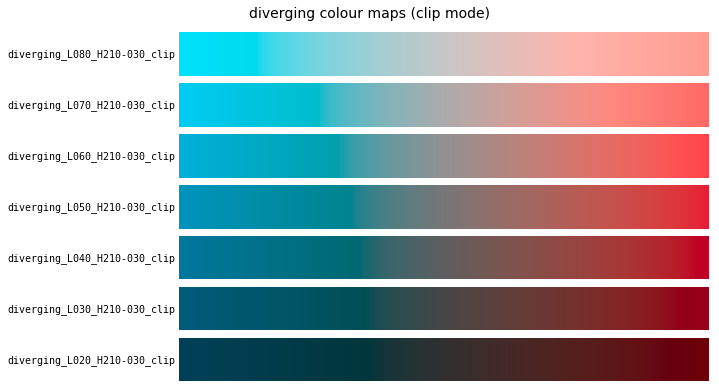

In [26]:
maps.plot_cmaps(figsize=(figsize_x,figsize_y*7), dir=png_dir, title="diverging colour maps (clip mode)")

### Mono-hue

In [27]:
maps.make_cmap_favs(types=['monohue'], modes=['crop'], targets=['mpl'], plot=False)

-------
monohue
-------
creating cmap 'monohue_L000-050_H040_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H040_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H040_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H140_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H140_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H140_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H290_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H290_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H290_crop' for Matplotlib ( 501 steps)


found cmaps:  ['monohue_L100-050_H040_crop', 'monohue_L100-050_H140_crop', 'monohue_L100-050_H290_crop', 'monohue_L000-050_H040_crop', 'monohue_L000-050_H140_crop', 'monohue_L000-050_H290_crop', 'monohue_L000-100_H040_crop', 'monohue_L000-100_H140_crop', 'monohue_L000-100_H290_crop']
writing  ./maps/cmap256_monohue_L100-050_H040_crop.png
writing  ./maps/cmap256_monohue_L100-050_H140_crop.png
writing  ./maps/cmap256_monohue_L100-050_H290_crop.png
writing  ./maps/cmap256_monohue_L000-050_H040_crop.png
writing  ./maps/cmap256_monohue_L000-050_H140_crop.png
writing  ./maps/cmap256_monohue_L000-050_H290_crop.png
writing  ./maps/cmap256_monohue_L000-100_H040_crop.png
writing  ./maps/cmap256_monohue_L000-100_H140_crop.png
writing  ./maps/cmap256_monohue_L000-100_H290_crop.png
writing  ./maps/cmaps_mono-hue colour maps (crop mode).png


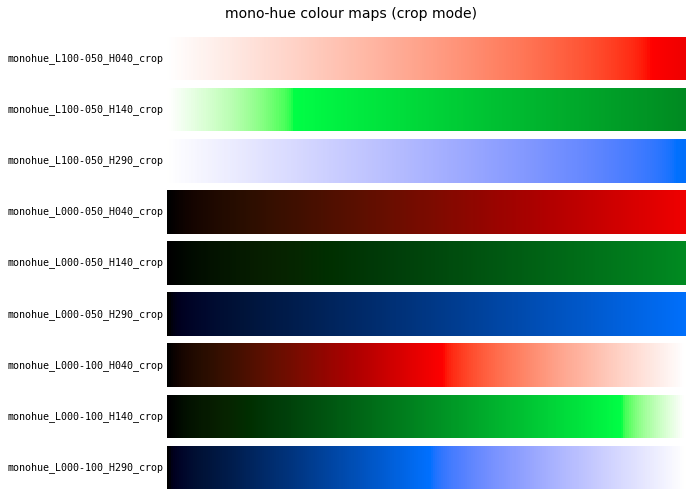

In [28]:
maps.plot_cmaps(figsize=(figsize_x,figsize_y*9), dir=png_dir, title="mono-hue colour maps (crop mode)")

In [29]:
maps.make_cmap_favs(types=['monohue'], modes=['clip'], targets=['mpl'], plot=False)

-------
monohue
-------
creating cmap 'monohue_L000-050_H040_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H040_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H040_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H140_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H140_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H140_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H290_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H290_clip' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H290_clip' for Matplotlib ( 501 steps)


found cmaps:  ['monohue_L100-050_H040_clip', 'monohue_L100-050_H140_clip', 'monohue_L100-050_H290_clip', 'monohue_L000-050_H040_clip', 'monohue_L000-050_H140_clip', 'monohue_L000-050_H290_clip', 'monohue_L000-100_H040_clip', 'monohue_L000-100_H140_clip', 'monohue_L000-100_H290_clip']
writing  ./maps/cmap256_monohue_L100-050_H040_clip.png
writing  ./maps/cmap256_monohue_L100-050_H140_clip.png
writing  ./maps/cmap256_monohue_L100-050_H290_clip.png
writing  ./maps/cmap256_monohue_L000-050_H040_clip.png
writing  ./maps/cmap256_monohue_L000-050_H140_clip.png
writing  ./maps/cmap256_monohue_L000-050_H290_clip.png
writing  ./maps/cmap256_monohue_L000-100_H040_clip.png
writing  ./maps/cmap256_monohue_L000-100_H140_clip.png
writing  ./maps/cmap256_monohue_L000-100_H290_clip.png
writing  ./maps/cmaps_mono-hue colour maps (clip mode).png


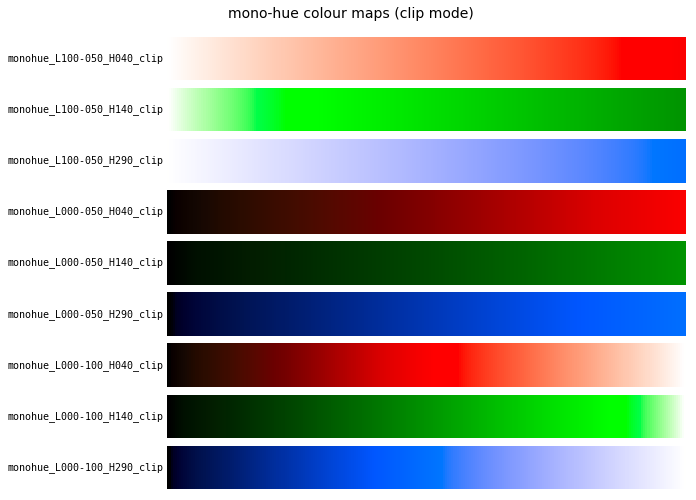

In [30]:
maps.plot_cmaps(figsize=(figsize_x,figsize_y*9), dir=png_dir, title="mono-hue colour maps (clip mode)")

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>
<br>Gilles Ferrand
<br>2020-05-21